Scripts

In [1]:
from newsapi import NewsApiClient
import datetime
import time
import pandas as pd
import os
from newspaper import Article
import sys

In [ ]:
# Initialize NewsAPI Client
api_key = ""  # Replace with API key
newsapi = NewsApiClient(api_key=api_key)

# Input and output file paths
input_file = "news_articles_election_candidates_expanded.csv"
full_content_file = "news_articles_election_candidates_full_content.csv"

# Function to fetch full article content using newspaper3k
def fetch_full_content(article_url):
    try:
        article = Article(article_url)
        article.download()
        article.parse()
        return article.text  # Return the full article text
    except Exception as e:
        return None  # Return None if there is an error

# Set new date range
start_date = datetime.date(2024, 10, 12)  # Continue from where the previous script left off
end_date = datetime.date(2024, 8, 1)  # Adjust end date as needed for backward collection

# Prepare to store results
articles_data = []

# Expanded search queries
queries = [
    "2024 Presidential election",
    "US election AND (Donald Trump OR Kamala Harris)",
    "Biden administration AND 2024 election",
    "(Donald Trump OR Trump) AND 2024 election",
    "(Kamala Harris OR Harris) AND 2024 election",
    "Campaign financing AND 2024 election",
    "Voter turnout AND 2024 election",
    "Presidential debate AND 2024 election",
    "(Donald Trump OR Trump) AND rally AND 2024",
    "(Kamala Harris OR Harris) AND speech AND 2024",
    "(Donald Trump OR Kamala Harris) AND 2024 election",
    "(Trump OR Harris) AND campaign AND 2024 election"
]

# Track API request count to avoid exceeding limits
request_count = 0
max_requests = 100  # Free-tier daily API limit

# Load existing expanded and full content CSV files
existing_expanded_data = pd.read_csv(input_file) if os.path.exists(input_file) else pd.DataFrame()
existing_full_content_data = pd.read_csv(full_content_file) if os.path.exists(full_content_file) else pd.DataFrame()

# Track URLs to avoid duplicates
existing_urls = set(existing_expanded_data["url"]) if not existing_expanded_data.empty else set()
processed_urls = set(existing_full_content_data["url"]) if not existing_full_content_data.empty else set()

# Fetch new articles from NewsAPI
current_date = start_date
while current_date >= end_date:
    # Convert date to string for API
    date_str = current_date.strftime('%Y-%m-%d')
    print(f"Fetching articles for {date_str}...")

    for query in queries:
        try:
            # Check if API limit is reached
            if request_count >= max_requests:
                print("Reached API limit for the day. Exiting script.")
                sys.exit()

            # Fetch articles for the current query and date
            response = newsapi.get_everything(
                q=query,
                from_param=date_str,
                to=date_str,
                language="en",
                sort_by="relevancy",  # Fetch relevant articles
                page_size=100  # Max articles per API call
            )

            # Increment request count
            request_count += 1

            if response.get('status') != 'ok':
                print(f"API error: {response.get('message')}")
                sys.exit()

            # Process the articles
            if response.get('articles'):
                for article in response['articles']:
                    # Only add new articles that are not already saved
                    if article['url'] not in existing_urls:
                        articles_data.append({
                            "query": query,  # Include the query used for tracking
                            "source": article['source']['name'],
                            "author": article['author'],
                            "title": article['title'],
                            "description": article['description'],
                            "url": article['url'],
                            "published_at": article['publishedAt'],
                            "content": article['content']
                        })
                        # Add the URL to the set of existing URLs
                        existing_urls.add(article['url'])
        except Exception as e:
            # Log the error to a file
            with open("error_log.txt", "a") as log_file:
                log_file.write(f"Error fetching articles for {query} on {date_str}: {e}\n")
            print(f"Error fetching articles for {query} on {date_str}: {e}")
    
    # Move to the previous day
    current_date -= datetime.timedelta(days=1)

    # Avoid hitting API limits by adding a small delay between requests
    time.sleep(1)

# Save new articles to the expanded CSV file
if articles_data:
    new_data_df = pd.DataFrame(articles_data)
    new_data_df.to_csv(input_file, mode='a', header=not os.path.exists(input_file), index=False)
    print(f"Appended {len(new_data_df)} new articles to '{input_file}'.")

# Extract full content for new articles only
new_urls = {article["url"] for article in articles_data}  # URLs of newly fetched articles
urls_to_process = new_urls - processed_urls  # Exclude already processed URLs

if urls_to_process:
    full_content_data = []
    for url in urls_to_process:
        print(f"Fetching full content for {url}...")
        full_content = fetch_full_content(url)
        if full_content:
            full_content_data.append({
                "url": url,
                "full_content": full_content
            })
        else:
            print(f"Failed to fetch full content for {url}")

    # Append full content to the full content CSV file
    if full_content_data:
        full_content_df = pd.DataFrame(full_content_data)
        full_content_df.to_csv(full_content_file, mode='a', header=not os.path.exists(full_content_file), index=False)
        print(f"Appended {len(full_content_df)} new full content articles to '{full_content_file}'.")
else:
    print("No new articles to process for full content.")



Remove entries with missing full content

START

In [2]:
import pandas as pd
data_full_content = pd.read_csv('news_articles_election_candidates_full_content_cleaned.csv')

# NER

In [3]:
import networkx as nx
import spacy
from collections import defaultdict
import requests
import spacy.cli
import json

# Download the en_core_web_trf model
spacy.cli.download("en_core_web_trf")

# Process only the first 100 articles for testing
data_sample = data_full_content.head(100)

# Load the spaCy English model
nlp = spacy.load("en_core_web_trf")

# Collect authors' names to exclude them from entities
authors_set = set()
for author in data_sample['author'].dropna():
    # Some articles may have multiple authors separated by commas
    authors = [a.strip() for a in author.split(',')]
    authors_set.update(authors)

# Lowercase authors' names for consistent comparison
authors_set = {author.lower() for author in authors_set}

# Function to retrieve U.S. politicians and their aliases
def get_current_us_congress_members():
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT DISTINCT ?person ?personLabel ?aliasLabel WHERE {
      VALUES ?position { wd:Q13217683 wd:Q13218630 }  # U.S. Senator and Representative
      ?person p:P39 ?positionStatement.
      ?positionStatement ps:P39 ?position;
                         pq:P580 ?startTime.
      FILTER NOT EXISTS { ?positionStatement pq:P582 ?endTime. }  # Position with no end time
      OPTIONAL { ?person skos:altLabel ?aliasLabel FILTER (LANG(?aliasLabel) = "en") }
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    '''
    headers = {'Accept': 'application/sparql-results+json'}
    response = requests.get(url, params={'query': query}, headers=headers, timeout=60)
    if response.status_code != 200:
        raise Exception(f"SPARQL query failed with status {response.status_code}: {response.text}")
    data = response.json()

    politician_aliases = {}
    for item in data['results']['bindings']:
        canonical_name = item['personLabel']['value']
        alias = item.get('aliasLabel', {}).get('value')
        if canonical_name not in politician_aliases:
            politician_aliases[canonical_name] = set()
            politician_aliases[canonical_name].add(canonical_name)
        if alias:
            politician_aliases[canonical_name].add(alias)
    return politician_aliases


# Retrieve the U.S. politicians and their aliases
politician_aliases_raw = get_current_us_congress_members()

# Load manual politician data from JSON file
def load_manual_politicians(file_path="manual_politicians.json"):
    try:
        with open(file_path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"File not found: {file_path}. Using an empty dictionary.")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

# Load manual politicians
manual_politicians = load_manual_politicians()

# Add manual politicians to the alias dictionary
politician_aliases_raw.update(manual_politicians)

# Logging function to verify additions
def log_aliases(aliases):
    print("Manual politician aliases added:")
    for canonical_name, aliases_set in aliases.items():
        print(f"{canonical_name}: {', '.join(aliases_set)}")

# Log the manual politician data being added
log_aliases(manual_politicians)


# Build the alias_to_canonical mapping
alias_to_canonical = {}
for canonical_name, aliases in politician_aliases_raw.items():
    for alias in aliases:
        alias_to_canonical[alias.lower()] = canonical_name

# Initialize mappings for mentions
article_mentions = defaultdict(set)  # Maps article index to mentioned politicians
politician_mentions = defaultdict(set)  # Maps politician to articles they're mentioned in

# Perform NER and normalize entity names
# Process articles
for idx, row in data_sample.iterrows():
    content = row['full_content']
    doc = nlp(content)
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            entity_name = ent.text.strip()
            entity_name_lower = entity_name.lower()
            # Exclude authors
            if entity_name_lower in authors_set:
                continue
            # Map entity name to canonical politician name
            canonical_name = alias_to_canonical.get(entity_name_lower)
            if canonical_name:
                article_mentions[idx].add(canonical_name)
                politician_mentions[canonical_name].add(idx)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 52.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `w

Manual politician aliases added:
Joe Biden: Joe Biden, Joseph Biden, Biden, President Biden, Uncle Joe, Sleepy Joe
Donald Trump: Donald Trump, Trump, President Trump, The Donald, DJT, 45, Former President Trump
Kamala Harris: Kamala Harris, Harris, Vice President Harris, Kamala, VP Harris, KDH
Ron DeSantis: Ron DeSantis, DeSantis, Governor DeSantis, Ron, Ron DeSanctimonious
Gavin Newsom: Gavin Newsom, Newsom, Governor Newsom, Gavin, Governor Hair Gel
Nikki Haley: Nikki Haley, Haley, Ambassador Haley, Nikki, Nimrata
Mike Pence: Mike Pence, Pence, Vice President Pence, Mike, Mr. Pious
Bernie Sanders: Bernie Sanders, Sanders, Senator Sanders, Bernie, Bern, The Bern
Chuck Schumer: Chuck Schumer, Schumer, Senator Schumer, Majority Leader Schumer, Cryin' Chuck
Mitch McConnell: Mitch McConnell, McConnell, Senator McConnell, Cocaine Mitch, Moscow Mitch
Kevin McCarthy: Kevin McCarthy, McCarthy, Speaker McCarthy, Kevin, My Kevin
Marjorie Taylor Greene: Marjorie Taylor Greene, MTG, Greene, Repres

/Users/thomasschioler/anaconda3/envs/02805SG/lib/python3.11/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


KeyboardInterrupt: 

### 1. Cell for Setup (Run Once)
This cell performs tasks that only need to be done once, such as downloading the spaCy model and loading manual politician data.

In [4]:
# Import necessary libraries
import spacy
import requests
import json

# Download the spaCy model (Run this only once)
try:
    import spacy.cli
    spacy.cli.download("en_core_web_trf")
except Exception as e:
    print("Model download skipped or already complete:", e)

# Load the spaCy English model
nlp = spacy.load("en_core_web_trf")

# Load manual politician data from JSON file
def load_manual_politicians(file_path="manual_politicians.json"):
    try:
        with open(file_path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"File not found: {file_path}. Using an empty dictionary.")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

# Load manual politicians (only needs to be loaded once)
manual_politicians = load_manual_politicians()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 51.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


### 2. Cell for Data Retrieval and Processing
Use this cell for tasks that depend on external data or need to be re-executed when the data changes (e.g., fetching politician aliases).

In [5]:
from collections import defaultdict

# Function to retrieve U.S. politicians and their aliases
def get_current_us_congress_members():
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT DISTINCT ?person ?personLabel ?aliasLabel WHERE {
      VALUES ?position { wd:Q13217683 wd:Q13218630 }  # U.S. Senator and Representative
      ?person p:P39 ?positionStatement.
      ?positionStatement ps:P39 ?position;
                         pq:P580 ?startTime.
      FILTER NOT EXISTS { ?positionStatement pq:P582 ?endTime. }  # Position with no end time
      OPTIONAL { ?person skos:altLabel ?aliasLabel FILTER (LANG(?aliasLabel) = "en") }
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    '''
    headers = {'Accept': 'application/sparql-results+json'}
    response = requests.get(url, params={'query': query}, headers=headers, timeout=60)
    if response.status_code != 200:
        raise Exception(f"SPARQL query failed with status {response.status_code}: {response.text}")
    data = response.json()

    politician_aliases = {}
    for item in data['results']['bindings']:
        canonical_name = item['personLabel']['value']
        alias = item.get('aliasLabel', {}).get('value')
        if canonical_name not in politician_aliases:
            politician_aliases[canonical_name] = set()
            politician_aliases[canonical_name].add(canonical_name)
        if alias:
            politician_aliases[canonical_name].add(alias)
    return politician_aliases

# Fetch U.S. politician aliases
politician_aliases_raw = get_current_us_congress_members()

# Merge with manual politicians
politician_aliases_raw.update(manual_politicians)

# Build alias-to-canonical mapping
alias_to_canonical = {}
for canonical_name, aliases in politician_aliases_raw.items():
    for alias in aliases:
        alias_to_canonical[alias.lower()] = canonical_name


### Cell for Article Processing
This cell processes your dataset (data_sample) and performs named entity recognition (NER). Run it whenever you need to process or analyze new articles.

In [6]:
import pandas as pd
import os
import pickle
from collections import defaultdict

# Assume data_full_content is already loaded
data_sample = data_full_content.head(8000)

# Collect authors' names to exclude them from entities
authors_set = set()
for author in data_sample['author'].dropna():
    authors = [a.strip() for a in author.split(',')]
    authors_set.update(authors)

# Lowercase authors' names for consistent comparison
authors_set = {author.lower() for author in authors_set}

# Initialize mappings for mentions
article_mentions = defaultdict(set)  # Maps article index to mentioned politicians
politician_mentions = defaultdict(set)  # Maps politician to articles they're mentioned in

# Define paths to save progress
article_mentions_file = "article_mentions.pkl"
politician_mentions_file = "politician_mentions.pkl"
error_log_file = "error_log.txt"

# Load intermediate progress if available
if os.path.exists(article_mentions_file):
    with open(article_mentions_file, "rb") as f:
        article_mentions = pickle.load(f)
if os.path.exists(politician_mentions_file):
    with open(politician_mentions_file, "rb") as f:
        politician_mentions = pickle.load(f)

# Initialize or load error log
error_log = []
if os.path.exists(error_log_file):
    with open(error_log_file, "r") as f:
        error_log = f.readlines()

# Process articles
for idx, row in data_sample.iterrows():
    try:
        # Skip already processed articles
        if idx in article_mentions:
            continue

        content = row['full_content']
        doc = nlp(content)

        for ent in doc.ents:
            if ent.label_ == "PERSON":
                entity_name = ent.text.strip()
                entity_name_lower = entity_name.lower()
                # Exclude authors
                if entity_name_lower in authors_set:
                    continue
                # Map entity name to canonical politician name
                canonical_name = alias_to_canonical.get(entity_name_lower)
                if canonical_name:
                    article_mentions[idx].add(canonical_name)
                    politician_mentions[canonical_name].add(idx)

        # Periodically save progress
        if idx % 100 == 0:
            with open(article_mentions_file, "wb") as f:
                pickle.dump(article_mentions, f)
            with open(politician_mentions_file, "wb") as f:
                pickle.dump(politician_mentions, f)
            print(f"Progress saved at article {idx}")

    except Exception as e:
        # Log the error
        error_message = f"Error processing article {idx}: {str(e)}\n"
        error_log.append(error_message)
        with open(error_log_file, "a") as f:
            f.write(error_message)
        print(error_message)

# Final save of progress
with open(article_mentions_file, "wb") as f:
    pickle.dump(article_mentions, f)
with open(politician_mentions_file, "wb") as f:
    pickle.dump(politician_mentions, f)

print("Processing complete.")


Progress saved at article 500
Progress saved at article 2100
Progress saved at article 2600
Progress saved at article 2700
Progress saved at article 2800
Progress saved at article 2900
Progress saved at article 3000
Progress saved at article 3100
Progress saved at article 3200
Progress saved at article 3300
Progress saved at article 3400
Progress saved at article 3500
Progress saved at article 3600
Progress saved at article 3700
Progress saved at article 3800
Progress saved at article 3900
Progress saved at article 4000
Progress saved at article 4100
Progress saved at article 4200
Progress saved at article 4300
Progress saved at article 4400
Progress saved at article 4500
Progress saved at article 4600
Progress saved at article 4700
Progress saved at article 4800
Progress saved at article 4900
Progress saved at article 5000
Progress saved at article 5100
Progress saved at article 5200
Progress saved at article 5300
Progress saved at article 5400
Progress saved at article 5500
Progress 

# Creating the network

In [7]:
# Create the network graph
G = nx.Graph()

# Add nodes with attributes (politicians and articles)
for politician, articles in politician_mentions.items():
    G.add_node(politician, articles=list(articles))

# Add edges based on co-mentions in articles
for article_idx, mentioned_politicians in article_mentions.items():
    mentioned_politicians = list(mentioned_politicians)
    for i in range(len(mentioned_politicians)):
        for j in range(i + 1, len(mentioned_politicians)):
            p1, p2 = mentioned_politicians[i], mentioned_politicians[j]
            if G.has_edge(p1, p2):
                G[p1][p2]['weight'] += 1
            else:
                G.add_edge(p1, p2, weight=1)

# Output graph information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("Sample nodes with attributes:")
for node, attrs in list(G.nodes(data=True))[:5]:
    print(f"{node}: {attrs}")
print("Sample edges with weights:")
for u, v, attrs in list(G.edges(data=True))[:5]:
    print(f"{u} - {v}: {attrs}")

Number of nodes: 299
Number of edges: 3308
Sample nodes with attributes:
Donald Trump: {'articles': [0, 1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 33, 34, 38, 40, 42, 43, 45, 48, 49, 50, 51, 52, 53, 55, 57, 58, 64, 65, 67, 69, 70, 71, 74, 75, 76, 77, 78, 82, 83, 84, 85, 86, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 191, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241,

100%|██████████| 2000/2000 [00:01<00:00, 1170.64it/s]


BarnesHut Approximation  took  0.53  seconds
Repulsion forces  took  0.95  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


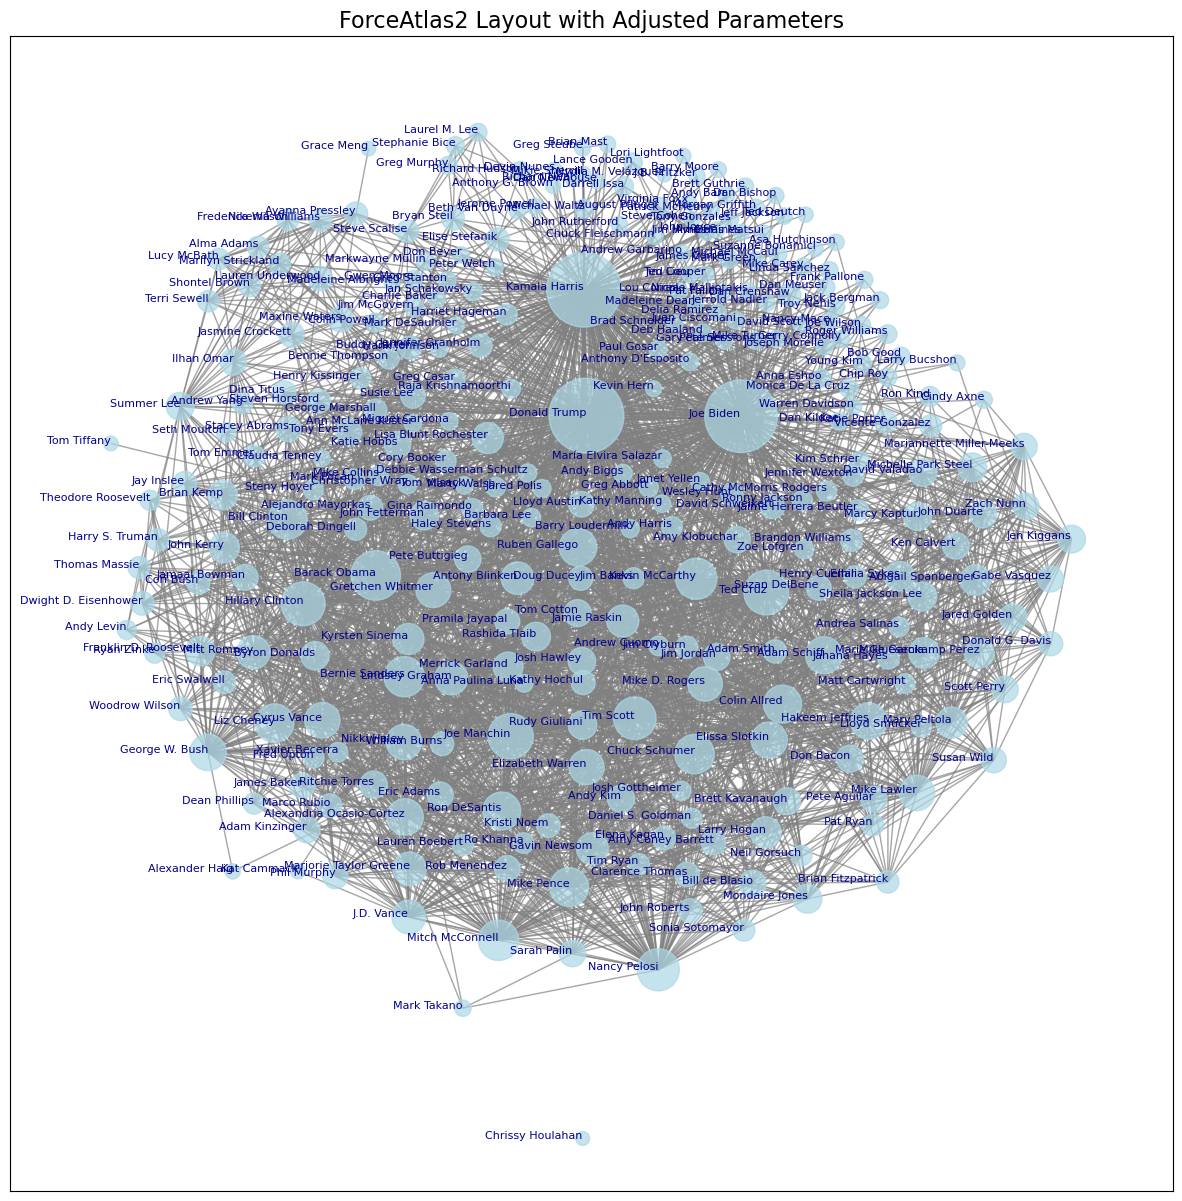

In [8]:
from fa2_modified import ForceAtlas2
import networkx as nx
import matplotlib.pyplot as plt

# Create the ForceAtlas2 instance with adjusted parameters
forceatlas2 = ForceAtlas2(
    jitterTolerance=1.0,  # Stability threshold
    barnesHutOptimize=True,  # Optimize layout for large graphs
    barnesHutTheta=1.5,  # Adjust theta for better spreading
    scalingRatio=100.0,  # Increase spacing between nodes
    strongGravityMode=True,  # Disable strong gravity
    gravity=0.01,  # Spread nodes outward
    verbose=True  # Output progress details
)

# Compute the ForceAtlas2 layout
positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

# Adjust node sizes dynamically based on degree
node_sizes = [100 + 10 * G.degree(n) for n in G.nodes()]

# Visualization
plt.figure(figsize=(15, 15))  # Increase figure size
nx.draw_networkx(
    G,
    pos=positions,
    with_labels=False,  # Temporarily hide labels
    node_size=node_sizes,  # Adjust node sizes
    node_color='lightblue',  # Set node color
    edge_color='gray',  # Set edge color
    alpha=0.7  # Set transparency
)

# Add labels separately to reduce overlap
for node, (x, y) in positions.items():
    plt.text(x, y, s=node, fontsize=8, ha='right', color='darkblue')

# Add a title
plt.title("ForceAtlas2 Layout with Adjusted Parameters", fontsize=16)

# Display the graph
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1235.28it/s]


BarnesHut Approximation  took  0.50  seconds
Repulsion forces  took  0.88  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


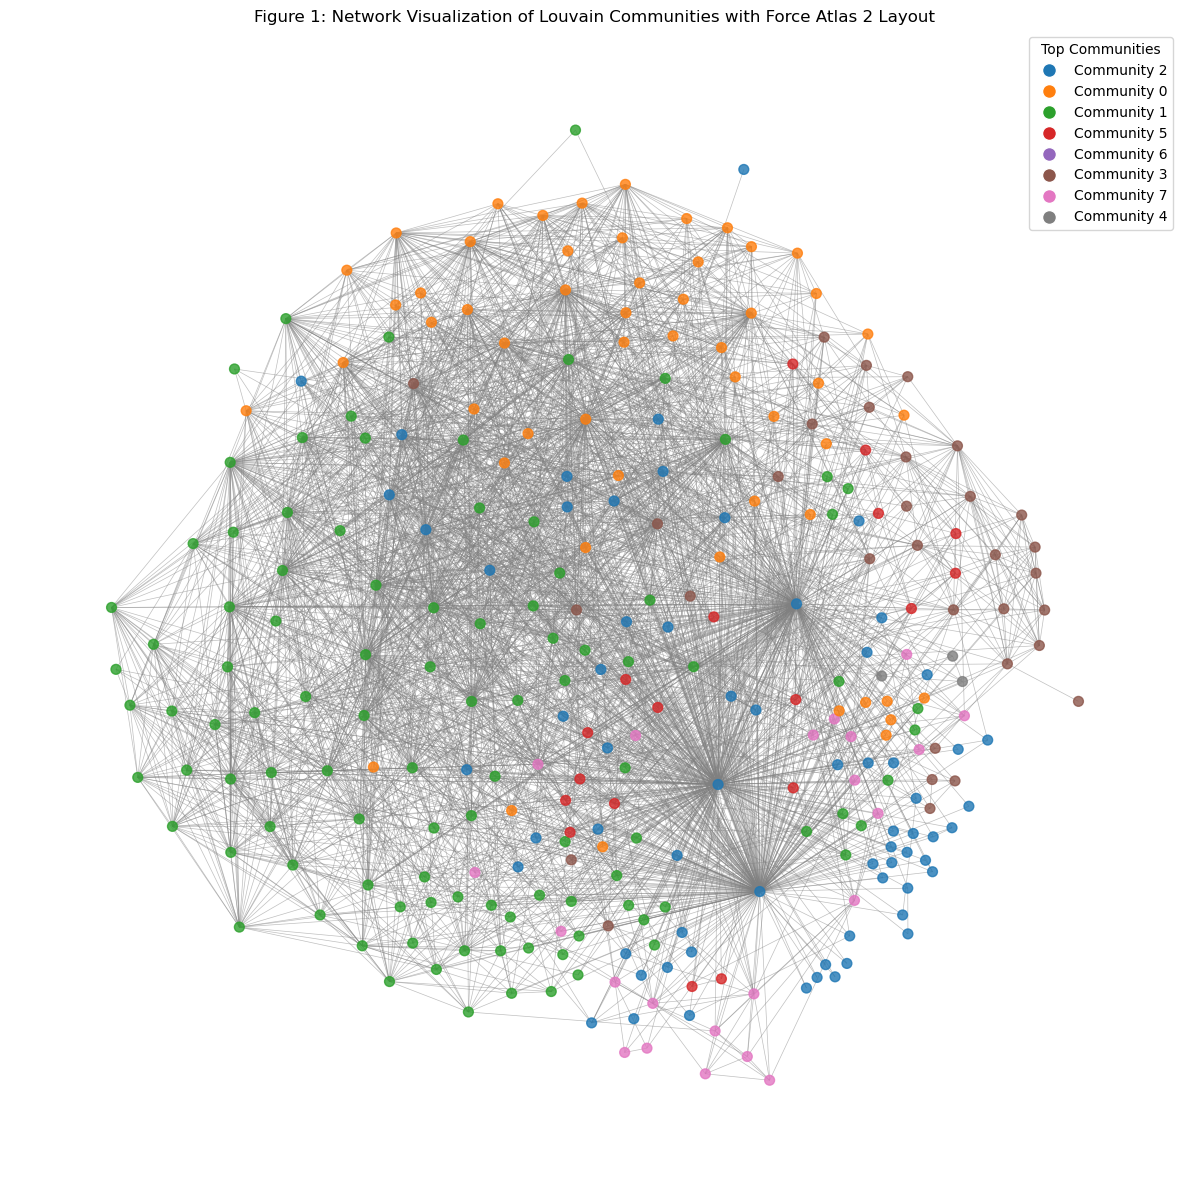

In [9]:
#make community detection
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from collections import Counter


# Compute the best partition
partition = community_louvain.best_partition(G)

# Analyze community structure
community_sizes = Counter(partition.values())
sorted_communities = community_sizes.most_common()

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# Prepare visualization with colors for top communities
top_communities = [community for community, size in sorted_communities[:10]]
color_map = plt.get_cmap('tab10')
node_colors = []

for node in G.nodes():
    community_id = partition[node]
    node_colors.append(color_map(community_id % 10) if community_id in top_communities else 'lightgray')

# Compute Force Atlas 2 layout
forceatlas2 = ForceAtlas2(
     outboundAttractionDistribution=False,
     linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,  # Stability threshold
    barnesHutOptimize=True,  # Optimize layout for large graphs
    barnesHutTheta=1.5,  # Adjust theta for better spreading
    scalingRatio=100.0,  # Increase spacing between nodes
    strongGravityMode=True,  # Disable strong gravity
    gravity=0.01,  # Spread nodes outward
    verbose=True  # Output progress details
)
positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

# Draw the network with community colors
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, positions, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, positions, edge_color='gray', alpha=0.5, width=0.5)
plt.axis("off")

# Create legend for top communities
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f"Community {community}",
               markerfacecolor=color_map(i % 10), markersize=10) 
    for i, (community, _) in enumerate(sorted_communities[:10])
]
plt.legend(handles=handles, loc="best", title="Top Communities")
plt.title("Figure 1: Network Visualization of Louvain Communities with Force Atlas 2 Layout")
plt.tight_layout()
plt.show()


In [10]:
#print the score
print("Modularity score:", community_louvain.modularity(partition, G))


Modularity score: 0.10985985078362871
